# CNN MNIST Digit Recognizer

In [1]:
import sys
print(sys.executable)
print(sys.version)

c:\Python312\python.exe
3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

## Model Overview

### 1. Model Architecture (SimpleCNN)

The model is a sequential, "LeNet-style" Convolutional Neural Network consisting of two convolutional blocks followed by a classifier.

**Input:** `1 x 28 x 28` (Batch Size, Channels, Height, Width)

#### Convolutional Block 1
* **Layer 1 (Conv2d):**
    * **Number of Filters:** 32
    * **Kernel Size:** 5x5
    * **Stride:** 1
    * **Padding:** 2 (This padding is chosen to preserve the 28x28 dimensions after the 5x5 convolution).
* **Layer 2 (ReLU):**
    * **Activation Function:** Rectified Linear Unit (`nn.ReLU`).
* **Layer 3 (MaxPool2d):**
    * **Kernel Size:** 2x2
    * **Stride:** 2 (This downsamples the feature map).
* **Output of Block 1:** `32 x 14 x 14`

#### Convolutional Block 2
* **Layer 4 (Conv2d):**
    * **Number of Filters:** 64
    * **Kernel Size:** 5x5
    * **Stride:** 1
    * **Padding:** 2 (Preserves the 14x14 dimensions).
* **Layer 5 (ReLU):**
    * **Activation Function:** `nn.ReLU`.
* **Layer 6 (MaxPool2d):**
    * **Kernel Size:** 2x2
    * **Stride:** 2 (Downsamples the feature map).
* **Output of Block 2:** `64 x 7 x 7`

#### Classifier (Fully Connected Layers)
* **Layer 7 (Flatten):**
    * Converts the 3D feature map (`64 x 7 x 7`) into a 1D vector.
    * **Output Size:** `64 * 7 * 7 = 3136`
* **Layer 8 (Linear):**
    * **Input Features:** 3136
    * **Output Features:** 128
* **Layer 9 (ReLU):**
    * **Activation Function:** `nn.ReLU`.
* **Layer 10 (Dropout):**
    * **Regularization Technique:** Dropout
    * **Dropout Rate:** 0.5 (or 50%). Neurons are randomly zeroed out during training to prevent overfitting.
* **Layer 11 (Linear - Output Layer):**
    * **Input Features:** 128
    * **Output Features:** 10 (one for each digit class, 0-9).
* **Final Output:** `1 x 10` (Raw logits/scores for each class).

---

### 2. Training and Hyperparameters

* **Learning Rate:** `0.001`
* **Number of Epochs:** `10`
* **Batch Size:** `64`
* **Regularization:** `nn.Dropout` with `p=0.5` is the primary technique used.
* **Optimizer:** `Adam` (an adaptive learning rate optimization algorithm).

---

### 3. Other Technical Details

* **Loss Function:** `nn.CrossEntropyLoss`. This is the standard for multi-class classification. It conveniently combines a `LogSoftmax` operation and the Negative Log-Likelihood Loss (`NLLLoss`), so the model's output layer just needs to produce raw scores (logits).
* **Data Preprocessing:**
    1.  `transforms.ToTensor()`: Converts PIL images to PyTorch tensors and scales pixel values from the `[0, 255]` integer range to the `[0.0, 1.0]` float range.
    2.  `transforms.Normalize((0.1307,), (0.3081,))`: Standardizes the tensor data by subtracting the mean (`0.1307`) and dividing by the standard deviation (`0.3081`) of the MNIST dataset. This helps the model train faster and more stably.
* **Data Split Strategy:**
    * **Full Training Set:** 60,000 images from MNIST.
    * **Full Test Set:** 10,000 images from MNIST.
    * **Split:** The 60,000-image training set is split **before training** into:
        * **Training Subset:** 54,000 images (90% of the full set).
        * **Validation Subset:** 6,000 images (10% of the full set).
    * The model is trained on the **Training Subset** and its performance is checked against the **Validation Subset** at the end of each epoch. The final, unbiased performance is reported using the separate **Test Set**.

## Hyperparameters and setup

In [3]:
# --- Hyperparameters and Setup ---
DEVICE = torch.device("cpu")
LEARNING_RATE = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 10
DROPOUT_RATE = 0.5
TRAIN_VAL_SPLIT_RATIO = 0.9 # 90% for training, 10% for validation

## CNN Architecture

In [4]:
# --- 1. Define the CNN Architecture ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # Convolutional Block 1
        # Input: 1x28x28
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=32, 
            kernel_size=5, 
            stride=1, 
            padding=2
        )
        # After conv1: 32x28x28
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # After pool1: 32x14x14

        # Convolutional Block 2
        # Input: 32x14x14
        self.conv2 = nn.Conv2d(
            in_channels=32, 
            out_channels=64, 
            kernel_size=5, 
            stride=1, 
            padding=2
        )
        # After conv2: 64x14x14
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # After pool2: 64x7x7
        
        # Classifier (Fully Connected Layers)
        self.flatten = nn.Flatten()
        # Input size to FC layer: 64 * 7 * 7 = 3136
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        # Conv Block 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Conv Block 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Classifier
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x) # Logits (raw scores)
        
        return x

## Load Data and Define DataLoaders

In [5]:
# --- 2. Load Data and Define DataLoaders ---
def get_dataloaders():
    # Standard transforms for MNIST
    # ToTensor() scales images from [0, 255] to [0.0, 1.0]
    # Normalize() standardizes the data. (0.1307,) and (0.3081,) are
    # the pre-calculated mean and std dev of the MNIST dataset.
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Download the full training dataset (60,000 images)
    full_train_dataset = datasets.MNIST(
        root='./data', 
        train=True, 
        transform=transform, 
        download=True
    )
    
    # Download the test dataset (10,000 images)
    test_dataset = datasets.MNIST(
        root='./data', 
        train=False, 
        transform=transform, 
        download=True
    )
    
    # Split the full training dataset into training and validation sets
    train_size = int(len(full_train_dataset) * TRAIN_VAL_SPLIT_RATIO)
    val_size = len(full_train_dataset) - train_size
    
    train_subset, val_subset = random_split(
        full_train_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42) # for reproducible splits
    )
    
    print(f"Total training images: {len(train_subset)}")
    print(f"Total validation images: {len(val_subset)}")
    print(f"Total test images: {len(test_dataset)}")
    
    # Create DataLoaders for each set
    train_loader = DataLoader(
        dataset=train_subset, 
        batch_size=BATCH_SIZE, 
        shuffle=True
    )
    val_loader = DataLoader(
        dataset=val_subset, 
        batch_size=BATCH_SIZE, 
        shuffle=False
    )
    test_loader = DataLoader(
        dataset=test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False
    )
    
    return train_loader, val_loader, test_loader

## Training and Evaluation Loop

In [6]:
print(f"Using device: {DEVICE}")
    
# Get DataLoaders
train_loader, val_loader, test_loader = get_dataloaders()

# Initialize model, loss function, and optimizer
model = SimpleCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss() # Combines LogSoftmax and NLLLoss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# History lists to store metrics
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

Using device: cpu
Total training images: 54000
Total validation images: 6000
Total test images: 10000


In [7]:
print("\n--- Starting Training ---")
total_train_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    # --- NEW: Timer for one epoch ---
    epoch_start_time = time.time()
    
    # --- Training Phase ---
    model.train() # Set model to training mode (enables dropout)
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to the device
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # --- Forward pass ---
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # --- Backward pass and optimization ---
        optimizer.zero_grad() # Clear old gradients
        loss.backward()       # Calculate new gradients
        optimizer.step()        # Update model parameters
        
        running_train_loss += loss.item()
        
        # --- NEW: Calculate training accuracy ---
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    # Calculate average training loss and accuracy
    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_acc = 100 * train_correct / train_total
    
    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode (disables dropout)
    running_val_loss = 0.0 # <--- NEW
    val_correct = 0
    val_total = 0
    
    with torch.no_grad(): # Disable gradient calculation
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(images)
            
            # --- NEW: Calculate validation loss ---
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()
            
            # Get the class with the highest score
            _, predicted = torch.max(outputs.data, 1)
            
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    # Calculate average validation loss and accuracy
    avg_val_loss = running_val_loss / len(val_loader) # <--- NEW
    avg_val_accuracy = 100 * val_correct / val_total
    
    # --- NEW: Record metrics in history ---
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(avg_train_acc)
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(avg_val_accuracy)
    
    # --- NEW: Calculate epoch duration ---
    epoch_end_time = time.time()
    epoch_duration_s = epoch_end_time - epoch_start_time
    
    # --- UPDATED Print Statement ---
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train: Loss={avg_train_loss:.4f}, Acc={avg_train_acc:.2f}% | "
          f"Val Loss={avg_val_loss:.4f}, Acc={avg_val_accuracy:.2f}% | "
          f"Duration: {epoch_duration_s:.2f}s")

total_train_end_time = time.time()
total_train_duration_m = (total_train_end_time - total_train_start_time) / 60.0
print(f"Total Training Time: {total_train_duration_m:.2f} minutes")
print("--- Finished Training ---")


--- Starting Training ---
Epoch [1/10] | Train: Loss=0.2182, Acc=93.32% | Val Loss=0.0626, Acc=98.32% | Duration: 45.74s
Epoch [2/10] | Train: Loss=0.0816, Acc=97.69% | Val Loss=0.0465, Acc=98.70% | Duration: 45.25s
Epoch [3/10] | Train: Loss=0.0587, Acc=98.27% | Val Loss=0.0382, Acc=98.97% | Duration: 43.90s
Epoch [4/10] | Train: Loss=0.0486, Acc=98.61% | Val Loss=0.0450, Acc=98.83% | Duration: 45.56s
Epoch [5/10] | Train: Loss=0.0405, Acc=98.79% | Val Loss=0.0397, Acc=98.87% | Duration: 46.53s
Epoch [6/10] | Train: Loss=0.0340, Acc=98.99% | Val Loss=0.0343, Acc=99.08% | Duration: 43.39s
Epoch [7/10] | Train: Loss=0.0304, Acc=99.12% | Val Loss=0.0390, Acc=99.02% | Duration: 44.35s
Epoch [8/10] | Train: Loss=0.0276, Acc=99.14% | Val Loss=0.0438, Acc=98.82% | Duration: 46.22s
Epoch [9/10] | Train: Loss=0.0236, Acc=99.24% | Val Loss=0.0370, Acc=99.00% | Duration: 44.55s
Epoch [10/10] | Train: Loss=0.0214, Acc=99.33% | Val Loss=0.0388, Acc=98.93% | Duration: 45.99s
Total Training Time: 7

## Final Evaluation on Test Set

In [8]:
# --- 4. Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set ---")
model.eval() # Set model to evaluation mode
correct = 0
total = 0

# --- NEW: Lists to store predictions and labels ---
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # --- NEW: Store predictions and labels ---
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


--- Evaluating on Test Set ---
Final Test Accuracy: 99.14%


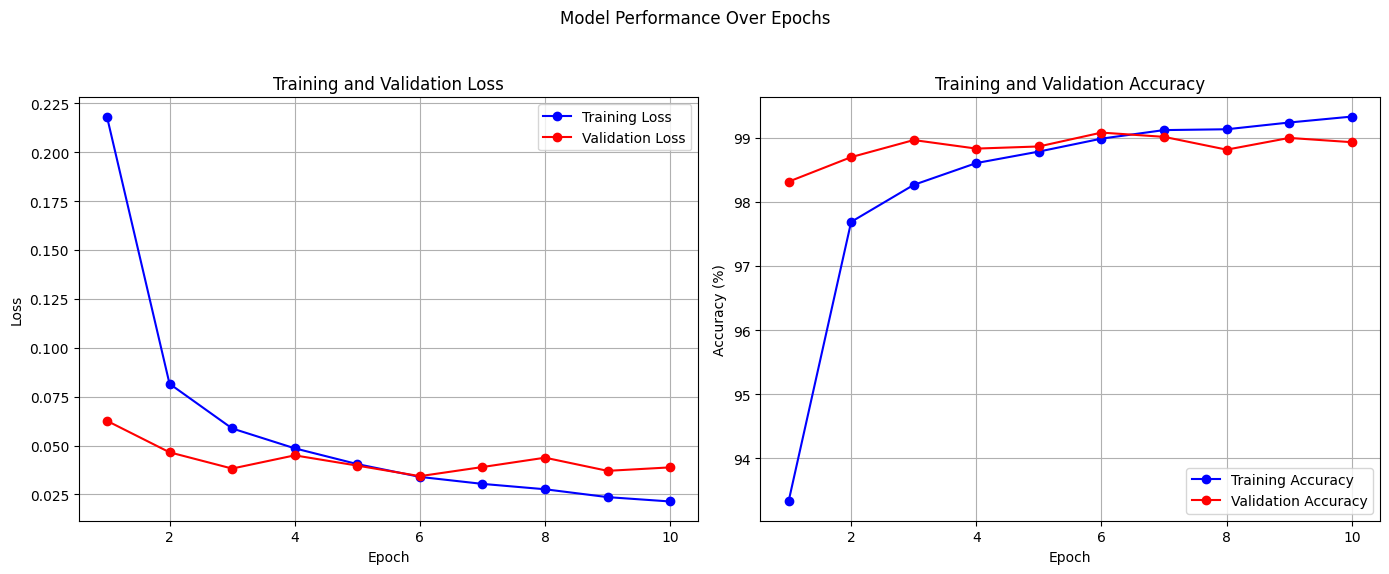

In [9]:
# --- Plotting training and validation metrics ---
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 6))

# Plot 1: Loss vs. Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss_history, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy vs. Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_history, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc_history, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.suptitle('Model Performance Over Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Generating Confusion Matrix ---


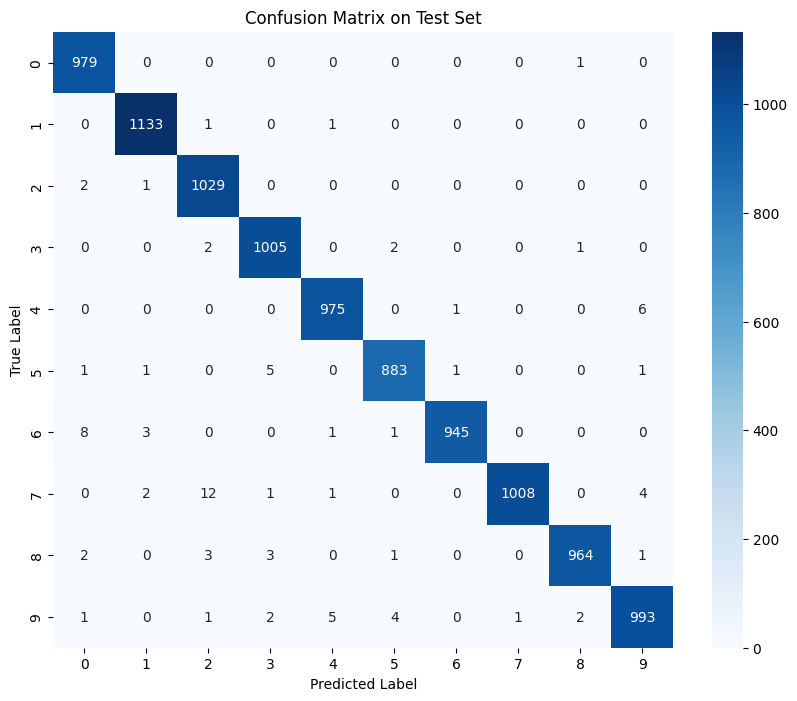

In [10]:
# --- Generating the confusion matrix heatmap ---
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)

# Get class names (digits 0-9)
class_names = [str(i) for i in range(10)]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names
)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [11]:
# --- Save the trained model ---
print("\n--- Saving Model ---")

# Define the directory and file path
SAVE_DIR = "bin"
MODEL_NAME = "mnist_cnn_model.pt"
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, MODEL_NAME)

# Create the 'bin' directory if it doesn't exist
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model's state dictionary
try:
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved successfully at: {MODEL_SAVE_PATH}")
except Exception as e:
    print(f"Error saving model: {e}")


--- Saving Model ---
Model saved successfully at: bin\mnist_cnn_model.pt
